# Neural network based integrator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/em459-neuralnetworkintegrators-4558d770a7c6")

import numpy as np
from matplotlib import pyplot as plt
from dynamical_system import *
from time_integrator import *
from neuralnet import *

np.random.seed(2512517)

## Initialise network and verlet integrator parameters


Set system parameters.

The model system we are using here is the Henon-Heiles system, an example of a chaotic system.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 4)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 16)           0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           1088        ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                              

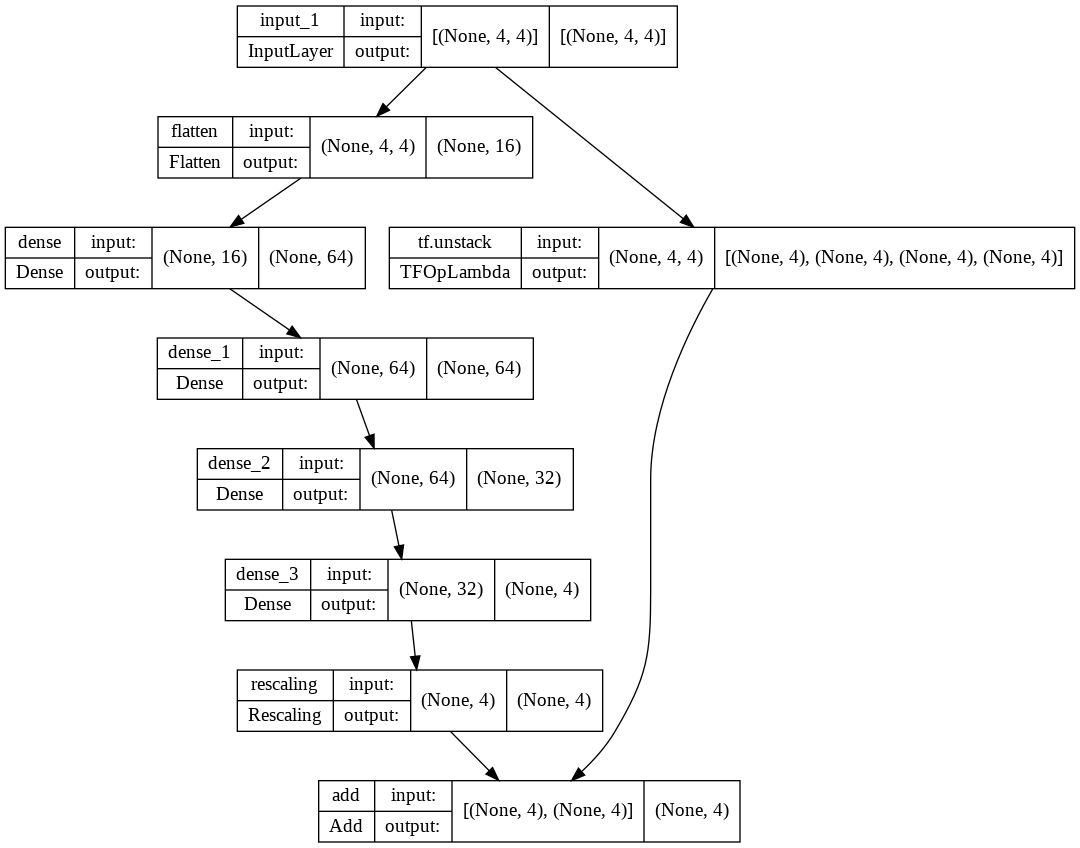

In [ ]:
# mass of orbital object
mass = 1
# timestep for Verlet integrator
dt_verlet = 0.001
# timestep for neural network integrator
dt_1 = dt_verlet
dt_2 = 20*dt_verlet
dt_3 = 40*dt_verlet
dt_4 = 100*dt_verlet
# number of steps for neural network integrator
nsteps = 4

henon_heiles = HenonHeiles(mass)

verlet_DP = VerletIntegrator(henon_heiles,dt_verlet)

nn_integrator_1 = NN5LR3Integrator(henon_heiles,nsteps,dt_1)
nn_integrator_2 = NN5LR3Integrator(henon_heiles,nsteps,dt_2)
nn_integrator_3 = NN5LR3Integrator(henon_heiles,nsteps,dt_3)
nn_integrator_4 = NN5LR3Integrator(henon_heiles,nsteps,dt_4)

# visualise the neural network model
nn_integrator_1.model.summary()
keras.utils.plot_model(nn_integrator_1.model, show_shapes=True)

The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{(t+(S-1)\Delta t)},\qquad\qquad y_j = q_j^{(t+S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},\dots,q_j^{(t+(S-1)\Delta t)}, q_j^{(t+S\Delta t)}$ are generated with a training generator (=Verlet) that is run with a smaller timestep.

In [ ]:
BATCH_SIZE=128

data_generator_1 = DataGenerator(nn_integrator_1,verlet_DP)
train_batches_1 = data_generator_1.dataset.batch(BATCH_SIZE)

data_generator_2 = DataGenerator(nn_integrator_2,verlet_DP)
train_batches_2 = data_generator_2.dataset.batch(BATCH_SIZE)

data_generator_3 = DataGenerator(nn_integrator_3,verlet_DP)
train_batches_3 = data_generator_3.dataset.batch(BATCH_SIZE)

data_generator_4 = DataGenerator(nn_integrator_4,verlet_DP)
train_batches_4 = data_generator_4.dataset.batch(BATCH_SIZE)


## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [ ]:
EPOCHS=300
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = nn_integrator_1.model.fit(train_batches_1,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_2 = nn_integrator_2.model.fit(train_batches_2,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_3 = nn_integrator_3.model.fit(train_batches_3,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=tensorboard_cb)
result_4 = nn_integrator_4.model.fit(train_batches_4,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)


Epoch 1/300
100/100 [==============================] - 9s 79ms/step - loss: 4.6555e-05
Epoch 2/300
100/100 [==============================] - 5s 54ms/step - loss: 4.1642e-05
Epoch 3/300
100/100 [==============================] - 6s 61ms/step - loss: 4.0987e-05
Epoch 4/300
100/100 [==============================] - 5s 52ms/step - loss: 3.9147e-05
Epoch 5/300
100/100 [==============================] - 5s 52ms/step - loss: 3.6399e-05
Epoch 6/300
100/100 [==============================] - 6s 56ms/step - loss: 3.2870e-05
Epoch 7/300
100/100 [==============================] - 6s 56ms/step - loss: 2.8834e-05
Epoch 8/300
100/100 [==============================] - 6s 55ms/step - loss: 2.4122e-05
Epoch 9/300
100/100 [==============================] - 6s 60ms/step - loss: 2.0194e-05
Epoch 10/300
100/100 [==============================] - 5s 47ms/step - loss: 1.8015e-05
Epoch 11/300
100/100 [==============================] - 5s 46ms/step - loss: 1.5079e-05
Epoch 12/300
100/100 [===================

## Visualise Loss function

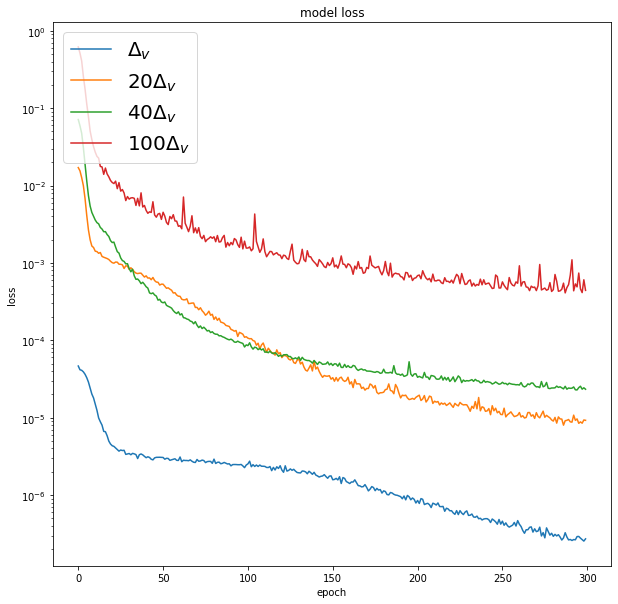

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])
plt.plot(result_2.history['loss'])
plt.plot(result_3.history['loss'])
plt.plot(result_4.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['$\Delta_v$','$20\Delta_v$','$40\Delta_v$','$100\Delta_v$'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories generated to $t=32$ by Verlet integrator and neural 


In [ ]:
# Final time
T_final = 32

n_step = int(T_final/dt_verlet)

# Initial conditions
x = np.zeros((1,2))
v = np.zeros((1,2))
x[0] = [-0.1,-0.2]
v[0] = [-0.2,-0.05]
verlet_DP.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_DP = np.zeros(n_step)
x_verlet_DP = np.zeros((n_step,2))
v_verlet_DP = np.zeros((n_step,2))
E_verlet_DP = np.zeros(n_step)


for k in range(n_step):
    t_verlet_DP[k] = t
    E_verlet_DP[k] = verlet_DP.energy()
    x_verlet_DP[k,:] = verlet_DP.x[:]
    v_verlet_DP[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(1)
    t += dt_verlet
        

In [ ]:
# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
x_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))
v_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))



verlet_DP.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_DP.x[:]
    v_initial_1[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_1/dt_verlet))
verlet_DP.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_DP.x[:]
    v_initial_2[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_2/dt_verlet))
verlet_DP.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_DP.x[:]
    v_initial_3[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_3/dt_verlet))
verlet_DP.set_state(x,v)
for k in range(nn_integrator_4.nsteps):    
    x_initial_4[k,:] = verlet_DP.x[:]
    v_initial_4[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_4/dt_verlet))


nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt
nn_integrator_4.set_state(x_initial_4,v_initial_4)
t_4 = (nn_integrator_4.nsteps-1)*nn_integrator_4.dt



# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []
t_nn_4 = []
x_nn_4 = []
v_nn_4 = []
E_nn_4 = []


while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x)
    v_nn_1.append(nn_integrator_1.v)
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt_1
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x)
    v_nn_2.append(nn_integrator_2.v)
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt_2
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x)
    v_nn_3.append(nn_integrator_3.v)
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt_3
while t_4<T_final:
    t_nn_4.append(t_4)
    x_nn_4.append(nn_integrator_4.x)
    v_nn_4.append(nn_integrator_4.v)
    E_nn_4.append(nn_integrator_4.energy())
    nn_integrator_4.integrate(1)
    t_4 += dt_4
 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_nn_4 = np.array(x_nn_4)
x_verlet_DP = np.array(x_verlet_DP)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_nn_4 = np.array(v_nn_4)
v_verlet_DP = np.array(v_verlet_DP)




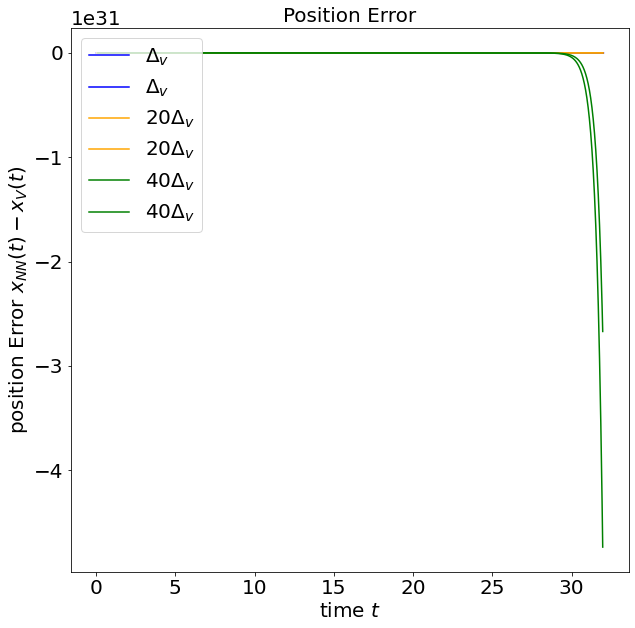

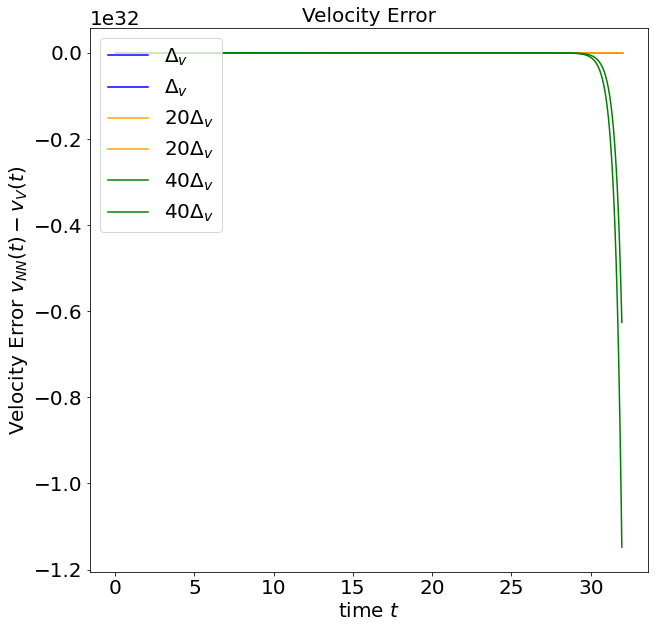

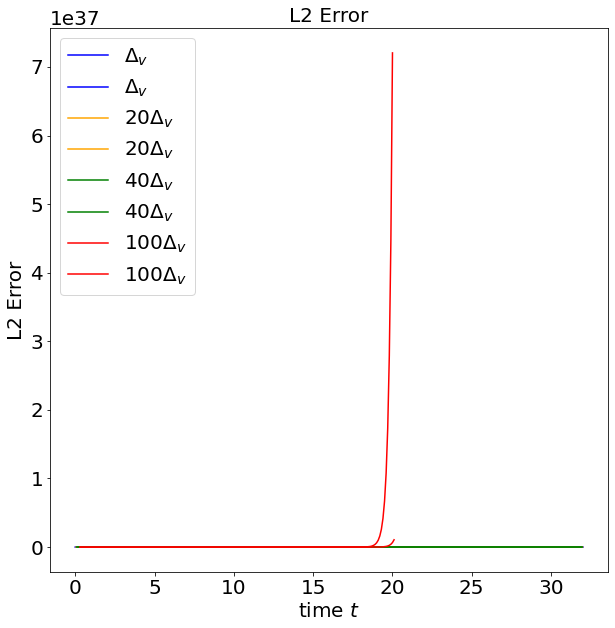

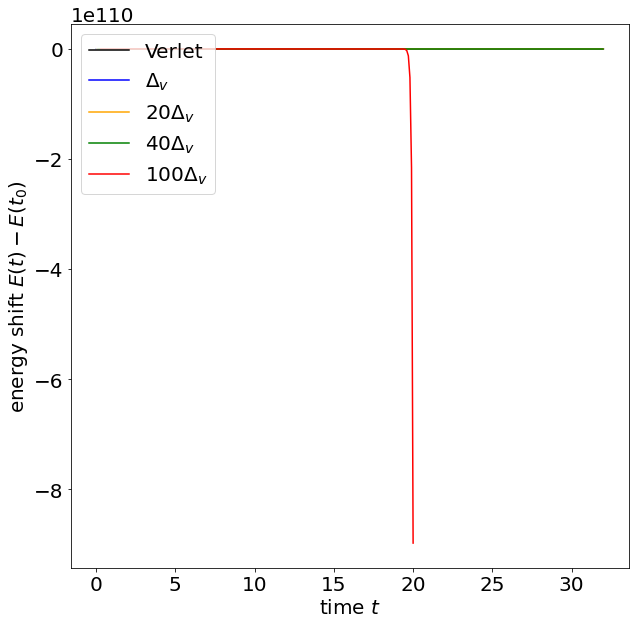

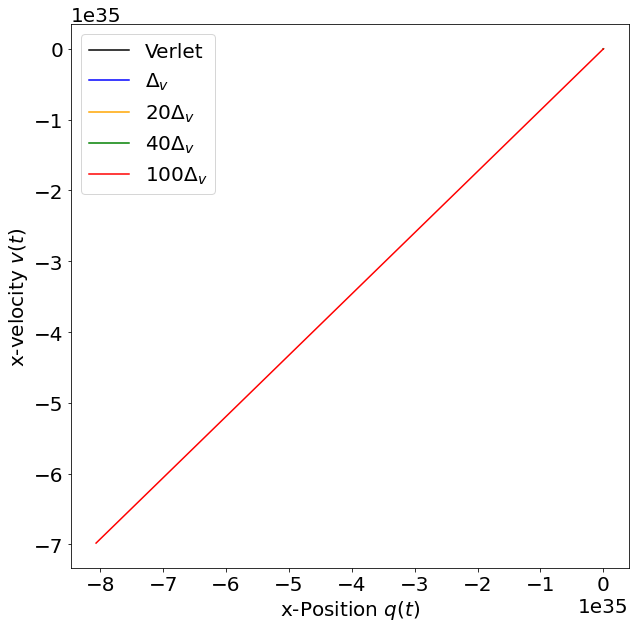

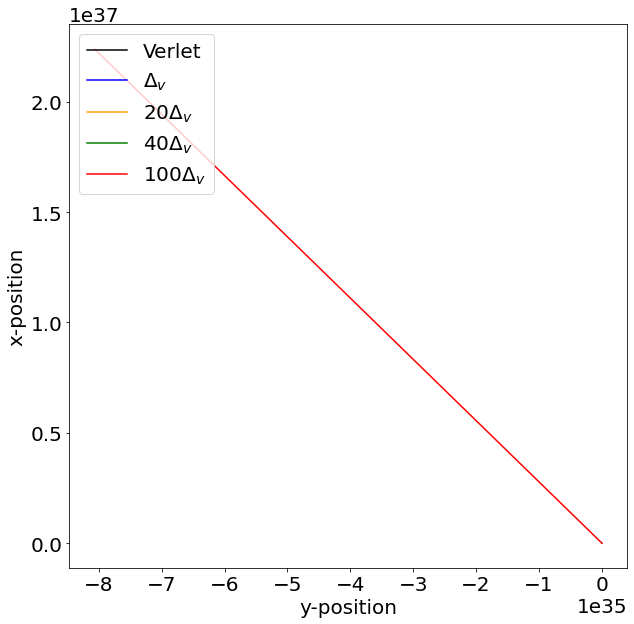

In [ ]:
# Plot norm of the x- and y- error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1[0:63997],x_nn_1[0:63997]-x_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2[0:1597],x_nn_2[0:1597]-x_verlet_DP[int((nsteps-1)*dt_2/dt_verlet)::int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3[0:797],x_nn_3[0:797]-x_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)][0:np.size(x_nn_3,0)],label='$40\Delta_v$',color='green')
#plt.plot(t_nn_4,x_nn_4-x_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)][0:np.size(x_nn_4)-2],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()



# Plot norm of the x- and y- velocity error as a function of time

plt.plot(t_nn_1[0:63997],v_nn_1[0:63997]-v_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2[0:1597],v_nn_2[0:1597]-v_verlet_DP[int((nsteps-1)*dt_2/dt_verlet)::int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3[0:797],v_nn_3[0:797]-v_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)][0:np.size(x_nn_3,0)],label='$40\Delta_v$',color='green')
#plt.plot(t_nn_4,v_nn_4-v_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)][0:np.size(x_nn_4)-2],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error of normed errors as a function of time

plt.plot(t_nn_1[0:63997],((v_nn_1[0:63997]-v_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2+(x_nn_1[0:63997]-x_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2)**0.5,label='$\Delta_v$',color='blue')
plt.plot(t_nn_2[0:1597],((v_nn_2[0:1597]-v_verlet_DP[int((nsteps-1)*dt_2/dt_verlet):int(np.size(v_verlet_DP)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2+(x_nn_2[0:1597]-x_verlet_DP[int((nsteps-1)*dt_2/dt_verlet):int(np.size(x_verlet_DP)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2)**0.5,label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3[0:797],((v_nn_3[0:797]-v_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2+(x_nn_3[0:797]-x_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2)**0.5,label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,((v_nn_4-v_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)][0:637])**2+(x_nn_4-x_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2)**0.5,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy drift as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_DP,E_verlet_DP-E_verlet_DP[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,E_nn_4-E_nn_4[0],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

#subplots of x- position and x- velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_DP[:,0],v_verlet_DP[:,0],label='Verlet',color='black')
plt.plot(x_nn_1[:,0],v_nn_1[:,0],label='$\Delta_v$',color='blue')
plt.plot(x_nn_2[:,0],v_nn_2[:,0],label='$20\Delta_v$',color='orange')
plt.plot(x_nn_3[:,0],v_nn_3[:,0],label='$40\Delta_v$',color='green')
plt.plot(x_nn_4[:,0],v_nn_4[:,0],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-velocity $v(t)$')
ax.set_xlabel('x-Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

#subplots of x- and y- position for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_DP[:,0],x_verlet_DP[:,1],label='Verlet',color='black')
plt.plot(x_nn_1[:,0],x_nn_1[:,1],label='$\Delta_v$',color='blue')
plt.plot(x_nn_2[:,0],x_nn_2[:,1],label='$20\Delta_v$',color='orange')
plt.plot(x_nn_3[:,0],x_nn_3[:,1],label='$40\Delta_v$',color='green')
plt.plot(x_nn_4[:,0],x_nn_4[:,1],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-position')
ax.set_xlabel('y-position')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

In [ ]:
x_verlet_DP[int((nsteps-1)*dt_2/dt_verlet)]

## Plot trajectories generated to $t=512$ by Verlet integrator and neural 


In [ ]:
# Final time
T_final = 512

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.70
v[0] = -0.6
verlet_DP.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_DP = []
x_verlet_DP = []
v_verlet_DP = []
E_verlet_DP = []



while t<T_final:
    t_verlet_DP.append(t)
    E_verlet_DP.append(verlet_DP.energy())
    x_verlet_DP.append(verlet_DP.x[0])
    v_verlet_DP.append(verlet_DP.v[0])
    verlet_DP.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
x_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))
v_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))



verlet_DP.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_DP.x[:]
    v_initial_1[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_1/dt_verlet))
verlet_DP.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_DP.x[:]
    v_initial_2[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_2/dt_verlet))
verlet_DP.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_DP.x[:]
    v_initial_3[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_3/dt_verlet))
verlet_DP.set_state(x,v)
for k in range(nn_integrator_4.nsteps):    
    x_initial_4[k,:] = verlet_DP.x[:]
    v_initial_4[k,:] = verlet_DP.v[:]
    verlet_DP.integrate(int(dt_4/dt_verlet))


nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt
nn_integrator_4.set_state(x_initial_4,v_initial_4)
t_4 = (nn_integrator_4.nsteps-1)*nn_integrator_4.dt



# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []
t_nn_4 = []
x_nn_4 = []
v_nn_4 = []
E_nn_4 = []


while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    v_nn_1.append(nn_integrator_1.v[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt_1
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    v_nn_2.append(nn_integrator_2.v[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt_2
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x[0])
    v_nn_3.append(nn_integrator_3.v[0])
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt_3
while t_4<T_final:
    t_nn_4.append(t_4)
    x_nn_4.append(nn_integrator_4.x[0])
    v_nn_4.append(nn_integrator_4.v[0])
    E_nn_4.append(nn_integrator_4.energy())
    nn_integrator_4.integrate(1)
    t_4 += dt_4
 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_nn_4 = np.array(x_nn_4)
x_verlet_DP = np.array(x_verlet_DP)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_nn_4 = np.array(v_nn_4)
v_verlet_DP = np.array(v_verlet_DP)




In [ ]:
# Plot angle error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1-x_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_DP[int((nsteps-1)*dt_2/dt_verlet):int(np.size(x_verlet_DP)-dt_2/dt_verlet):int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,x_nn_4-x_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot angular velocity error as a function of time

plt.plot(t_nn_1,v_nn_1-v_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_DP[int((nsteps-1)*dt_2/dt_verlet):int(np.size(v_verlet_DP)-dt_2/dt_verlet):int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,v_nn_4-v_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

plt.plot(t_nn_1,((v_nn_1-v_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2+(x_nn_1-x_verlet_DP[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2)**0.5,label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_DP[int((nsteps-1)*dt_2/dt_verlet):int(np.size(v_verlet_DP)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2+(x_nn_2-x_verlet_DP[int((nsteps-1)*dt_2/dt_verlet):int(np.size(x_verlet_DP)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2)**0.5,label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2+(x_nn_3-x_verlet_DP[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2)**0.5,label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,((v_nn_4-v_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2+(x_nn_4-x_verlet_DP[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_DP)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2)**0.5,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_DP,E_verlet_DP-E_verlet_DP[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,E_nn_4-E_nn_4[0],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

#subplots of angle versus angular velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_DP,v_verlet_DP,label='Verlet',color='black')
plt.plot(x_nn_1,v_nn_1,label='$\Delta_v$',color='blue')
plt.plot(x_nn_2,v_nn_2,label='$20\Delta_v$',color='orange')
plt.plot(x_nn_3,v_nn_3,label='$40\Delta_v$',color='green')
plt.plot(x_nn_4,v_nn_4,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('Velocity $v(t)$')
ax.set_xlabel('Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()